In [1]:
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append('../')
from dataset import *
import seaborn as sns

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path_template ='/home/ubuntu/data/logr/crand_%d/gan/model=gaussian_wgan-zdim=100-lr=-4.00-rep=2-run=1/samples%d.npz'

In [4]:
configs = [10, 15, 20, 30, 50, 60, 75, 100, 150, 200, 300, 400]
iteration = 14

In [5]:
gen_sample_list = []
true_sample_list = []
# Plot colors
import time
start_time = time.time()
for index, config in enumerate(configs):
    print("Loading %d, time elapsed = %.1f" % (config, time.time() - start_time))
    reader = np.load(path_template % (config, iteration))
    gen_samples = reader['g']
    true_samples = reader['x']
    gen_sample_list.append(gen_samples)
    true_sample_list.append(true_samples)

Loading 10, time elapsed = 0.0
Loading 15, time elapsed = 1.6
Loading 20, time elapsed = 3.2
Loading 30, time elapsed = 4.7
Loading 50, time elapsed = 6.3
Loading 60, time elapsed = 7.9
Loading 75, time elapsed = 9.5
Loading 100, time elapsed = 11.0
Loading 150, time elapsed = 12.6
Loading 200, time elapsed = 14.2
Loading 300, time elapsed = 15.8
Loading 400, time elapsed = 17.4


In [6]:
def eval_features(samples):
    sizes = np.expand_dims(DotsDataset.eval_size(samples), axis=1)
    locations = DotsDataset.eval_location(samples)
    proportions = np.expand_dims(DotsDataset.eval_color_proportion(samples), axis=1)
    # print(sizes.shape, locations.shape, proportions.shape)
    features = np.concatenate([sizes, locations, proportions], axis=1)
    # print(features.shape)
    size_bin = [0.0, 0.45, 0.55, 0.65, 1.00]
    locx_bin = [-1.0, -0.2, -0.05, 0.05, 0.2, 1.00]
    locy_bin = locx_bin
    proportion_bin = [0.0, 0.15, 0.25, 0.4, 0.65, 1.0] # color_list = [1, 2, 3, 5, 9]
    hist, _ = np.histogramdd(features, bins=[size_bin, locx_bin, locy_bin, proportion_bin])
    # print(hist.shape)
    hist = hist.astype(np.float)
    hist /= np.sum(hist)
    return hist

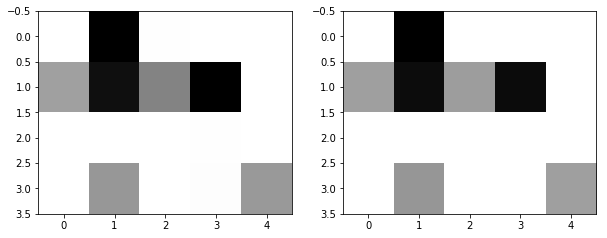

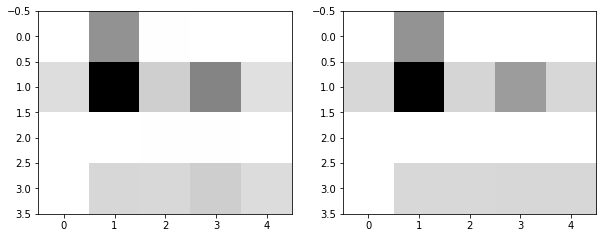

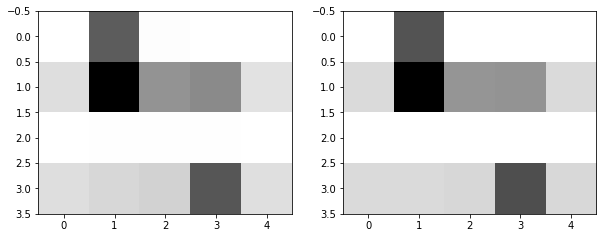

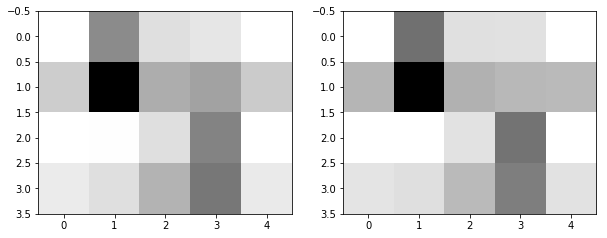

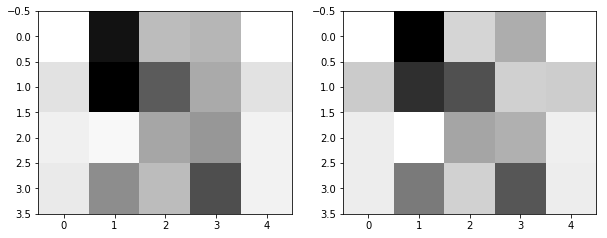

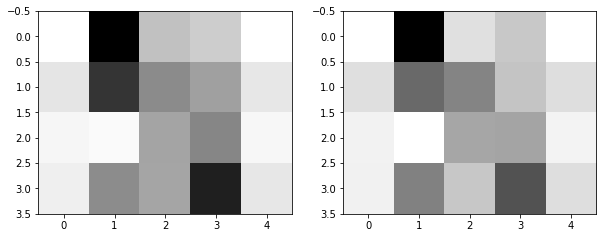

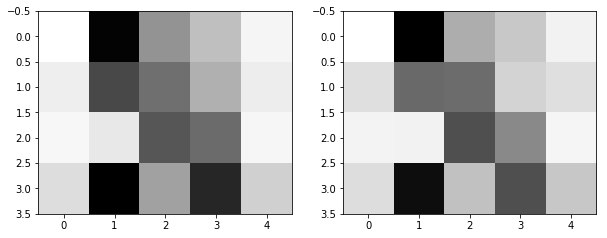

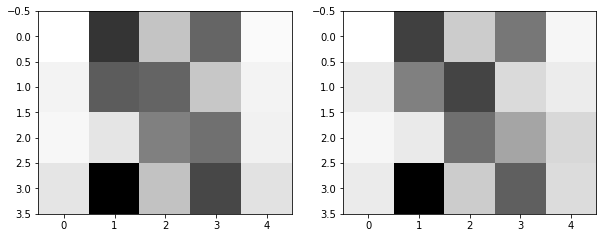

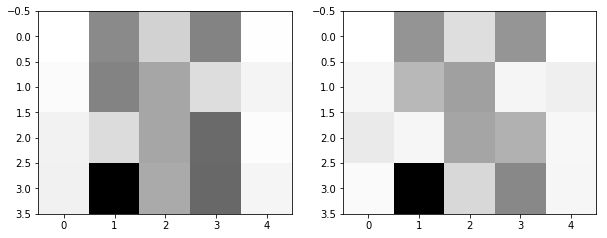

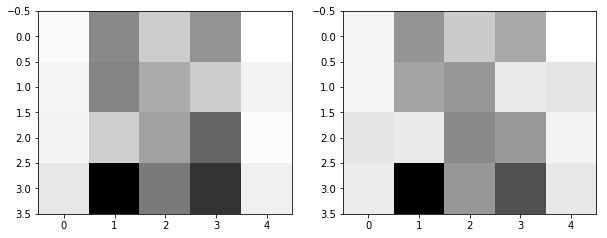

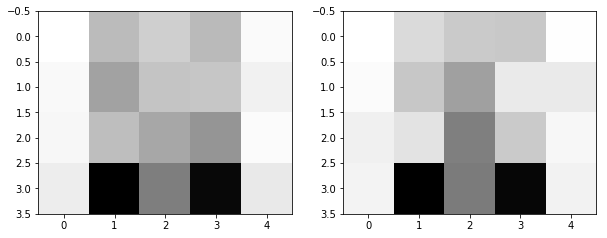

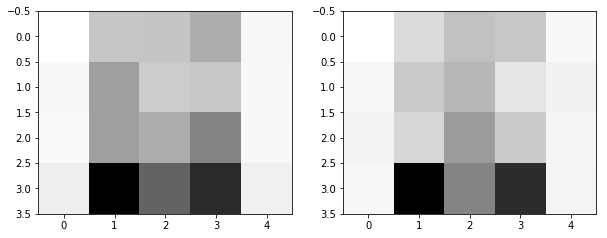

In [7]:
gen_hist_list = []
true_hist_list = []
# Plot colors
for index, config in enumerate(configs):
    plt.figure(figsize=(10, 4))
    gen_hist = eval_features(gen_sample_list[index])
    true_hist = eval_features(true_sample_list[index])
    gen_hist_list.append(gen_hist)
    true_hist_list.append(true_hist)
    plt.subplot(1, 2, 1)
    plt.imshow(np.sum(gen_hist, axis=(2, 3)), cmap='Greys')
    plt.subplot(1, 2, 2)
    plt.imshow(np.sum(true_hist, axis=(2, 3)), cmap='Greys')
    plt.show()

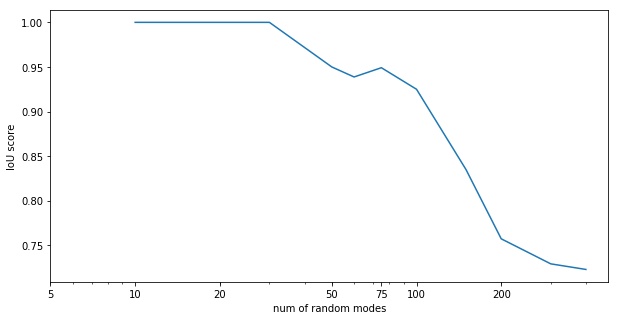

In [8]:
error = []
plt.figure(figsize=(10, 5))
for index, config in enumerate(configs):
    bin_hist_true = (true_hist_list[index] > 1.0 / config / 5.0).astype(np.float32)
    med_val = np.sort(gen_hist_list[index].flatten())[-int(np.sum(bin_hist_true))]
    bin_hist_gen = (gen_hist_list[index] >= med_val).astype(np.float32)
    # print(np.sum(bin_hist_true), np.sum(bin_hist))
    error.append(np.sum(bin_hist_gen * bin_hist_true) / np.sum(bin_hist_true))
plt.plot(configs, error)
plt.xscale('log')
plt.xticks([5, 10, 20, 50, 75, 100, 200], [5, 10, 20, 50, 75, 100, 200])
plt.xlabel('num of random modes')
plt.ylabel('IoU score')
# plt.savefig('../results/pr_random.pdf')
plt.show()

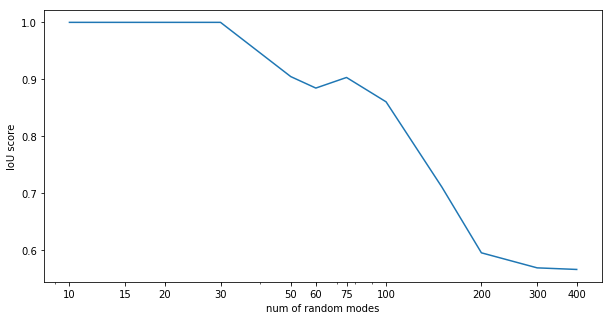

In [9]:
error = []
random_iou = []
plt.figure(figsize=(10, 5))
for index, config in enumerate(configs):
    bin_hist_true = (true_hist_list[index] > 1.0 / config / 3.0).astype(np.float32)
    med_val = np.sort(gen_hist_list[index].flatten())[-int(np.sum(bin_hist_true))]
    bin_hist_gen = (gen_hist_list[index] >= med_val).astype(np.float32)
    # bin_hist = (hist_list[index] > 1.0 / config / 3.0).astype(np.float32)
    # print(np.sum(bin_hist_true), np.sum(bin_hist))
    error.append(np.sum(bin_hist_gen * bin_hist_true) / np.sum(1.0 - (1.0 - bin_hist_true) * (1.0 - bin_hist_gen)))
    
    random_err = []
    for i in range(100):
        truth = np.zeros(shape=(500,))
        truth[:config] = 1.0
        false = np.random.permutation(truth)
        random_err.append(np.sum(truth * false) / np.sum(1.0 - (1.0 - truth) * (1.0 - false)))
    random_iou.append(np.mean(random_err))
plt.plot(configs, error)
# plt.plot(configs, random_iou)
plt.xscale('log')
plt.xticks([10, 15, 20, 30, 50, 60, 75, 100, 200, 300, 400], [10, 15, 20, 30, 50, 60, 75, 100, 200, 300, 400])
plt.xlabel('num of random modes')
plt.ylabel('IoU score')
#plt.savefig('../results/iou_random.pdf')
plt.show()

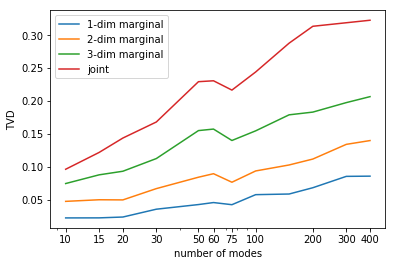

In [33]:
def distance_func(arr1, arr2):
    return 0.5 * np.sum(np.abs(arr1 / np.sum(arr1) - arr2 / np.sum(arr2)))

dist1_list, dist2_list, dist3_list, dist4_list = [], [], [], []
for index, config in enumerate(configs):
    gen_hist = gen_hist_list[index]
    true_hist = true_hist_list[index]
    
    sums1 = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]
    sums2 = [(0, 1), (1, 2), (2, 3), (0, 2), (0, 3), (1, 3)]
    sums3 = [(0,), (1,), (2,), (3,)]

    dist1 = np.mean([distance_func(np.sum(gen_hist, axis=axs), np.sum(true_hist, axis=axs)) for axs in sums1])
    dist2 = np.mean([distance_func(np.sum(gen_hist, axis=axs), np.sum(true_hist, axis=axs)) for axs in sums2])
    dist3 = np.mean([distance_func(np.sum(gen_hist, axis=axs), np.sum(true_hist, axis=axs)) for axs in sums3])
    dist4 = distance_func(gen_hist, true_hist)
    
    dist1_list.append(dist1)
    dist2_list.append(dist2)
    dist3_list.append(dist3)
    dist4_list.append(dist4)
plt.plot(configs, dist1_list, label='1-dim marginal')
plt.plot(configs, dist2_list, label='2-dim marginal')
plt.plot(configs, dist3_list, label='3-dim marginal')
plt.plot(configs, dist4_list, label='joint')
plt.xscale('log')
plt.legend()
plt.xticks([10, 15, 20, 30, 50, 60, 75, 100, 200, 300, 400], [10, 15, 20, 30, 50, 60, 75, 100, 200, 300, 400])
plt.xlabel('number of modes')
plt.ylabel('TVD')
plt.savefig('../../data/tvd_vs_marginal.pdf')
plt.show()

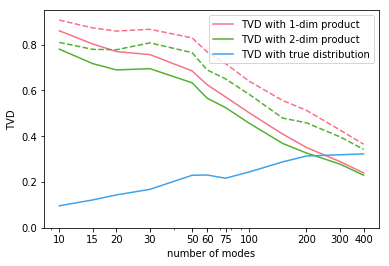

In [46]:
# Compare joint with product of marginals
def two_factor_error(hist):
    shape = list(hist.shape)
#     factor1 = np.sum(hist, axis=(0, 3), keepdims=True)
#     factor2 = np.sum(hist, axis=(1, 2), keepdims=True)
    
#     factor1 = np.tile(factor1, reps=[shape[0], 1, 1, shape[3]])
#     factor2 = np.tile(factor2, reps=[1, shape[1], shape[2], 1])
    
    factor1 = np.sum(hist, axis=(0, 1), keepdims=True)
    factor2 = np.sum(hist, axis=(2, 3), keepdims=True)
    
    factor1 = np.tile(factor1, reps=[shape[0], shape[1], 1, 1])
    factor2 = np.tile(factor2, reps=[1, 1, shape[2], shape[3]])
    
    prod_of_marginal = factor1 * factor2 
    return distance_func(hist, prod_of_marginal)
    
def one_factor_error(hist):
    factors = []
    for i in range(4):
        sums = [0, 1, 2, 3]
        sums.remove(i)
        factors.append(np.sum(hist, axis=tuple(sums), keepdims=True))
        tshapes = shape.copy()
        tshapes[i] = 1
        factors[-1] = np.tile(factors[-1], reps=tshapes)
    prod_of_marginal = factors[0] * factors[1] * factors[2] * factors[3]
    return distance_func(hist, prod_of_marginal)
    
dist_list_prod1 = []
dist_list_prod2 = []
dist_true_prod1 = []
dist_true_prod2 = []
dist_list_true = []
for index, config in enumerate(configs):
    gen_hist = gen_hist_list[index]
    true_hist = true_hist_list[index]
    
    dist_list_prod2.append(two_factor_error(gen_hist))
    dist_list_prod1.append(one_factor_error(gen_hist))
    dist_true_prod2.append(two_factor_error(true_hist))
    dist_true_prod1.append(one_factor_error(true_hist))
    dist_true = distance_func(gen_hist, true_hist)
    dist_list_true.append(dist_true)
    
plt.plot(configs, dist_list_prod1, label='TVD with 1-dim product', c=sns.color_palette('husl', 3)[0])
plt.plot(configs, dist_true_prod1, c=sns.color_palette('husl', 3)[0], ls='--')
plt.plot(configs, dist_list_prod2, label='TVD with 2-dim product', c=sns.color_palette('husl', 3)[1])
plt.plot(configs, dist_true_prod2, c=sns.color_palette('husl', 3)[1], ls='--')
plt.plot(configs, dist_list_true, label='TVD with true distribution', c=sns.color_palette('husl', 3)[2])
plt.xscale('log')
plt.ylim([0.0, 0.95])
plt.legend()
plt.xticks([10, 15, 20, 30, 50, 60, 75, 100, 200, 300, 400], [10, 15, 20, 30, 50, 60, 75, 100, 200, 300, 400])
plt.xlabel('number of modes')
plt.ylabel('TVD')
plt.savefig('../../data/tvd_vs_prod.pdf')
plt.show()

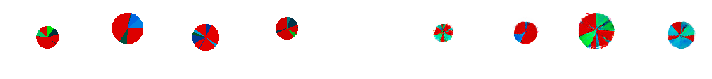

In [54]:
samples = gen_sample_list[10]
train_samples = true_sample_list[10]
plt.figure(figsize=(10, 1.8))
bias = 4
for idx in range(bias, bias+4):
    plt.subplot(1, 9, idx-bias+1)
    plt.imshow(train_samples[idx])
    plt.axis('off')
    plt.subplot(1, 9, idx-bias+6)
    plt.imshow(samples[idx])
    plt.axis('off')
plt.tight_layout()
plt.savefig('../../data/example_pie.pdf')
plt.show()